```{contents}
```
## Event-Driven Routing

**Event-Driven Routing** is a control-flow mechanism in LangGraph where **the next node is selected based on runtime events**, rather than a fixed static path.
This allows LangGraph systems to behave as **reactive, adaptive, and autonomous systems**.

---

### **1. Core Intuition**

Traditional pipelines:

```
A → B → C → D
```

Event-driven LangGraph:

```
          ┌─> Tool_Error ───┐
Input → Router ─> Success ──┼─> Final
          └─> Need_More_Info┘
```

Routing depends on **what happens**, not what was pre-defined.

---

### **2. What Is an “Event” in LangGraph?**

An **event** is any **state change or signal** produced during execution:

| Event Source      | Example                    |
| ----------------- | -------------------------- |
| LLM output        | `"need_more_info"`         |
| Tool response     | `"timeout"`, `"not_found"` |
| Human feedback    | `"approved"`               |
| System signal     | `"retry_limit_hit"`        |
| Validation result | `"invalid_format"`         |

Events are encoded inside the **shared state**.

---

### **3. Formal Model**

LangGraph routing is a function:

```
(state, event) → next_node
```

Where:

* **state** = current shared state
* **event** = value produced by last node
* **next_node** = node name to execute

---

### **4. Basic Event-Driven Routing Example**

### **State Schema**

```python
class State(TypedDict):
    query: str
    result: str
    event: str
```

### **Producer Node**

```python
def analyze(state):
    if "weather" in state["query"]:
        return {"event": "call_api"}
    else:
        return {"event": "direct_answer"}
```

### **Router**

```python
def route(state):
    return state["event"]
```

### **Graph Construction**

```python
builder.add_node("analyze", analyze)
builder.add_node("api", api_call)
builder.add_node("answer", direct_answer)

builder.set_entry_point("analyze")

builder.add_conditional_edges(
    "analyze",
    route,
    {
        "call_api": "api",
        "direct_answer": "answer"
    }
)
```

---

### **5. Event-Driven Looping**

```python
def monitor(state):
    if state["confidence"] < 0.8:
        return {"event": "retry"}
    return {"event": "done"}
```

```python
builder.add_conditional_edges(
    "monitor",
    lambda s: s["event"],
    {
        "retry": "analyze",
        "done": END
    }
)
```

This creates a **self-correcting feedback loop**.

---

### **6. Multi-Event Decision Table**

| Event            | Next Node |
| ---------------- | --------- |
| success          | finalize  |
| validation_error | fix       |
| tool_error       | fallback  |
| need_human       | review    |
| timeout          | retry     |

---

### **7. Real-World Use Cases**

| System               | Event Routing Purpose              |
| -------------------- | ---------------------------------- |
| Autonomous agent     | Adjust behavior from tool feedback |
| RAG system           | Decide when retrieval is required  |
| Compliance system    | Trigger human approval             |
| Monitoring system    | Self-healing actions               |
| Customer support bot | Escalate on failure                |

---

### **8. Production-Grade Enhancements**

| Feature        | Purpose             |
| -------------- | ------------------- |
| Timeout events | Prevent deadlocks   |
| Retry counters | Stop infinite loops |
| Event logs     | Full traceability   |
| Fallback paths | Fault tolerance     |
| Human events   | Governance          |

```python
graph.invoke(input, config={"recursion_limit": 15})
```

---

### **9. Variants of Event-Driven Routing**

| Variant                | Description                  |
| ---------------------- | ---------------------------- |
| State-based routing    | Event encoded in state       |
| Tool-driven routing    | Tool result triggers route   |
| Human-driven routing   | Manual event injection       |
| Policy-based routing   | Business rules decide        |
| Probabilistic routing  | Stochastic decision          |
| Learning-based routing | Router model learns behavior |

---

### **10. Why Event-Driven Routing Is Critical**

| Static Routing    | Event-Driven Routing |
| ----------------- | -------------------- |
| Fragile           | Robust               |
| Predictable       | Adaptive             |
| Manual handling   | Autonomous recovery  |
| Limited workflows | Real-world systems   |

---

### **11. Mental Model**

LangGraph becomes a **reactive control system**:

> **Observe → Decide → Act → Observe**

This is the foundation of **agents, autonomous pipelines, self-healing systems, and adaptive LLM applications**.


### Demonstration

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, END

# ------------------ State ------------------

class State(TypedDict):
    query: str
    result: str
    confidence: float
    attempts: int
    event: str

# ------------------ Nodes ------------------

def analyze(state: State):
    if "weather" in state["query"].lower():
        return {"event": "call_api"}
    return {"event": "direct_answer"}

def api_call(state: State):
    # Confidence improves each attempt (simulates learning)
    new_conf = min(1.0, state["confidence"] + 0.2)
    return {
        "result": "It is sunny",
        "confidence": new_conf,
        "attempts": state["attempts"] + 1,
    }

def direct_answer(state: State):
    return {
        "result": "Here is the answer",
        "confidence": 0.95,
        "attempts": state["attempts"] + 1,
    }

def monitor(state: State):
    if state["confidence"] < 0.8:
        return {"event": "retry"}
    return {"event": "done"}

# ------------------ Build Graph ------------------

builder = StateGraph(State)

builder.add_node("analyze", analyze)
builder.add_node("api", api_call)
builder.add_node("answer", direct_answer)
builder.add_node("monitor", monitor)

builder.set_entry_point("analyze")

builder.add_conditional_edges(
    "analyze",
    lambda s: s["event"],
    {
        "call_api": "api",
        "direct_answer": "answer",
    }
)

builder.add_edge("api", "monitor")
builder.add_edge("answer", "monitor")

builder.add_conditional_edges(
    "monitor",
    lambda s: s["event"],
    {
        "retry": "analyze",
        "done": END,
    }
)

graph = builder.compile()

# ------------------ Run ------------------

output = graph.invoke(
    {"query": "What is the weather?", "confidence": 0.0, "attempts": 0},
    config={"recursion_limit": 20},
)

print(output)


{'query': 'What is the weather?', 'result': 'It is sunny', 'confidence': 0.8, 'attempts': 4, 'event': 'done'}


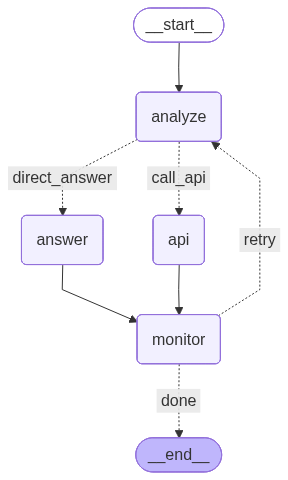

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())